# Deep Learning Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


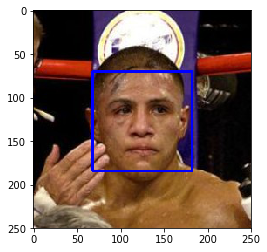

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

98% of the first 100 images in human_files have a detected human face

11% of the first 100 images in dog_files have a detected human face

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

true_human_count = len(list(filter(face_detector, human_files_short )))
false_human_count = len(list(filter(face_detector, dog_files_short )))

print('{}% of the first 100 images in human_files have a detected human face'.format(true_human_count))
print('{}% of the first 100 images in dog_files have a detected human face'.format(false_human_count))

98% of the first 100 images in human_files have a detected human face
11% of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ No it isn't. Training the model using augmented images of humans could help or ideally We could find the most prominent face in the image and crop it. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

## My Algorithm

The OpenCV face detector seemed to produce too many false positives and as such I thought there was room for improvement in the Face Detection Algorithm. I tried two approaches,

* Build a CNN and train it on the data
* Use a Support Vector Machine

I built a CNN based off the LeNet architecture and got somewhat poor results. I chose to start with Lenet since I read it did well on the MNIST dataset which has more classes than the 2 classes I wanted my network to classify (human or dog). It achieved about 60% validation accuarcy but did not improved over any number of epochs. Couldn't get it to improve no matter what I tried. 

After more reading I discovered this section in the SciKit Learn Documentation http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html. Which uses an SVC to classify handwritten digits and seemed to fit my problem perfectly as well. After applying this approached I was satisfied with the results which can be observed below. 

In [6]:
### Moved this cell block up to use it in algorithm
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Explore the data

Started by exploring the human face data to get an idea of the dictionary structure

In [7]:
human_data = load_files('lfw/')

In [8]:
data_keys = list(human_data.keys())

## Remove data I don't want to see in notebook
data_keys.remove('data')
data_keys.remove('DESCR')

data_keys

['target', 'filenames', 'target_names']

In [9]:
for i in range(5):
    for key in data_keys:
        print(human_data[key][i], end='----')
    print('\n')

906----lfw/Cherie_Blair/Cherie_Blair_0003.jpg----AJ_Cook----

1871----lfw/George_W_Bush/George_W_Bush_0075.jpg----AJ_Lamas----

5476----lfw/Tracee_Ellis_Ross/Tracee_Ellis_Ross_0002.jpg----Aaron_Eckhart----

5252----lfw/Tang_Jiaxuan/Tang_Jiaxuan_0009.jpg----Aaron_Guiel----

5738----lfw/Zhu_Rongji/Zhu_Rongji_0003.jpg----Aaron_Patterson----



In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Some images are pretty large and might be truncated

I figured 5000 images from each dataset was enough to use to train. I could've used the entire set but it seemed like an unnecessary waste of time considering the size

In [11]:
training_size = 5000

### Load training data

In [12]:
from keras.preprocessing import image  

human_filenames = np.array(human_data['filenames'])[:training_size]
human_tensors = paths_to_tensor(human_filenames).astype('float32')/255.

100%|██████████| 5000/5000 [00:08<00:00, 617.42it/s]


In [13]:
human_count = len(human_tensors)
print('{} human images'.format(human_count))
human_tensors.shape

5000 human images


(5000, 224, 224, 3)

In [14]:
dog_filenames = np.concatenate((train_files, valid_files, test_files))[:training_size]
dog_tensors = paths_to_tensor(dog_filenames).astype('float32')/255.

100%|██████████| 5000/5000 [00:39<00:00, 126.89it/s]


In [15]:
dog_count = len(dog_tensors)
print('{} dog images'.format(dog_count))
dog_tensors.shape

5000 dog images


(5000, 224, 224, 3)

### Label the data

I decided to model this as a simple classification problem either 1 for human or 0 for dog. This could have probably affected the effectiveness of the CNN since the results are discrete. I think if the labels were continuos the CNN might have fared better

In [16]:
human_labels = np.ones(human_count)
dog_labels = np.zeros(dog_count)

In [17]:
X = np.concatenate((human_tensors, dog_tensors))
y = np.concatenate((human_labels, dog_labels))

X.shape

(10000, 224, 224, 3)

Shuffle the data

In [18]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

I decided to set aside 500 images to test with once the SVC has been fitted

In [19]:
n = 500
X_test, y_test = X[-n:], y[-n:]
X, y = X[:-n], y[:-n]

In [20]:
n_samples = len(X)
print('{} samples'.format(n_samples))

9500 samples


### Classifier Training

A linear SVC with the default penalty parameter seemed to perform the best, I experimented with the various kernels available in the svm module.

In [21]:
from sklearn import datasets, svm
svc = svm.SVC(C=3, kernel='linear')
# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
X_shaped = X.reshape((n_samples, -1))
svc.fit(X_shaped[:n_samples//2], y[:n_samples//2])

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Score the performance of the Classifier

In [22]:
svc.score(X_shaped[n_samples//2:], y[n_samples//2:])

0.97726315789473683

In [23]:
X_test_shaped = X_test.reshape((n, -1))

In [24]:
test_result = svc.predict(X_test_shaped)

In [25]:
correct = 0
for i in range(n):
    if test_result[i] == y_test[i]:
        correct += 1

test_accuracy = correct/n * 100
print('{}% test accuracy'.format(test_accuracy))

98.8% test accuracy


The test accuracy isn't bad so I created a new face detector function to see how it does

In [26]:
def improved_face_detector(img_path):
    data = paths_to_tensor([img_path]).astype('float32')/255.
    data = data.reshape((1,-1))
    return svc.predict(data)[0]

In [27]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

true_human_count = len(list(filter(improved_face_detector, human_files_short )))
false_human_count = len(list(filter(improved_face_detector, dog_files_short )))

100%|██████████| 1/1 [00:00<00:00, 300.77it/s]


100%|██████████| 1/1 [00:00<00:00, 304.09it/s]


In [28]:
print('{}% of the first 100 images in human_files have a detected human face'.format(true_human_count))
print('{}% of the first 100 images in dog_files have a detected human face'.format(false_human_count))

97% of the first 100 images in human_files have a detected human face
2% of the first 100 images in dog_files have a detected human face


The number of false negatives increase slightly but there's a significant reduction in the number of false positives that I believe make this approach worthwhile

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [29]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [30]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [31]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

2% of the first 100 images in human_files have a detected dog face

100% of the first 100 images in dog_files have a detected dog face

In [32]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
false_dog_count = len(list(filter(dog_detector, human_files_short )))
true_dog_count = len(list(filter(dog_detector, dog_files_short )))

print('{}% of the first 100 images in human_files have a detected dog face'.format(false_dog_count))
print('{}% of the first 100 images in dog_files have a detected dog face'.format(true_dog_count))

2% of the first 100 images in human_files have a detected dog face
100% of the first 100 images in dog_files have a detected dog face


I also decided to test the previous SVM's performance in detecting dogs

In [33]:
f = lambda img: improved_face_detector(img) == 0
false_dog_count = len(list(filter(f, human_files_short )))
true_dog_count = len(list(filter(f, dog_files_short )))


100%|██████████| 1/1 [00:00<00:00, 313.62it/s]


100%|██████████| 1/1 [00:00<00:00, 303.03it/s]


In [34]:
print('{}% of the first 100 images in human_files have a detected dog face'.format(false_dog_count))
print('{}% of the first 100 images in dog_files have a detected dog face'.format(true_dog_count))

3% of the first 100 images in human_files have a detected dog face
98% of the first 100 images in dog_files have a detected dog face


It doesn't do as well here so it seems to be skewed a bit towards detecting human faces, so the default dog detector should do fine

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [35]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 142.62it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I decided to use the Lenet architecture. I chose this because since LeNet did decent enough at clasifying handwritten numbers from the MNIST dataset I figured it might do well enough here. Even though that problem only has 10 output classes whereas there's a bit more here.

In [36]:
kernel_size = 3
strides = 1
in_shape = (224, 224, 3)
pool_size = 2

In [37]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters = 16, kernel_size = kernel_size, strides=strides, padding='valid', activation='relu', input_shape=in_shape))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 32, kernel_size = kernel_size, strides=strides, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(500, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(300, activation='softmax'))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
__________

### Compile the Model

In [38]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

One of my intuitions about the dataset was about the lack of enough samples for specific classes so I decided to investigate it.

Training set count per class..


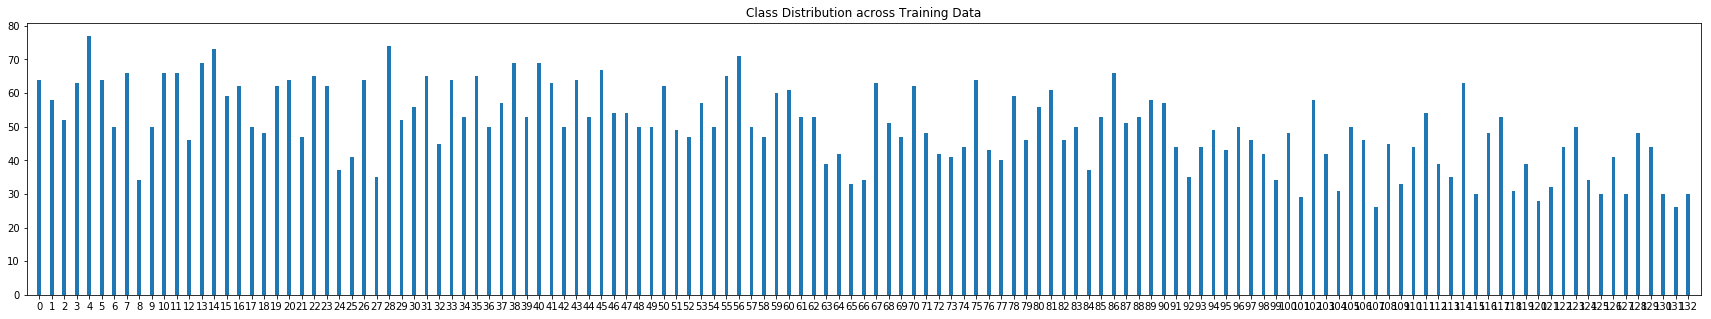

Minimum: Norwegian_buhund, 107 -> 26
Maximum: Alaskan_malamute, 4 -> 77


In [39]:
print("Training set count per class..")
class_count = [0]*133
class_images = [None]*133
feature_labels = [None]*133

for index, label in enumerate(train_targets):
    label_class = np.argmax(label)
    class_count[label_class] += 1
    class_images[label_class] = train_files[index]
    feature_labels[label_class] = label

min_class = 0
max_class = 0
for class_id, count in enumerate(class_count):
    if count < class_count[min_class]:
        min_class = class_id
    if count > class_count[max_class]:
        max_class = class_id
# Plot the histogram
plt.rcParams["figure.figsize"] = [30, 5]
axes = plt.gca()
axes.set_xlim([-1,133])

labels = range(133)
plt.bar(labels, class_count, tick_label=labels, width=0.3, align='center')
plt.title('Class Distribution across Training Data')
plt.show()
print("Minimum: {}, {} -> {}".format(dog_names[min_class], min_class, class_count[min_class]))
print("Maximum: {}, {} -> {}".format(dog_names[max_class], max_class, class_count[max_class]))

The class_images variable is used to store an image of each class to be augmented. It was hard to decided if choice of which image to augment was very important and owuld require more investigation of the data available. 

As can be observed some classes have less samples than a number of others. As well as a larger number of samples than those provided could improve the quality of the training results.

Before data augmentation the model achieved validation accuracy of 86%.

After a lot of research I was able to write code that could augment the images by using techniques that adjusted the brightness, rotated the image, translated the image and applied a shear affine transform. I read more about the Affine Transformation here https://homepages.inf.ed.ac.uk/rbf/HIPR2/affine.htm. Augmenting it myself instad of using the ImageDataGenerater provided by keraas allowed me to ensure an even distribution across the samples. 

In [40]:
def augment_brightness_images(image):
    '''
    Function to augment brightness
    '''
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [41]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    img = augment_brightness_images(img)

    return img

Afghan_hound


(-0.5, 359.5, 449.5, -0.5)

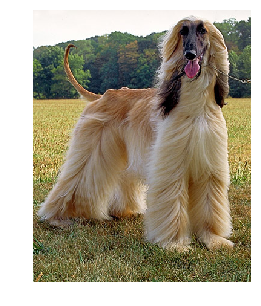

In [42]:
sample_index = 1
print(dog_names[sample_index])
sample_image = cv2.imread(class_images[sample_index])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')

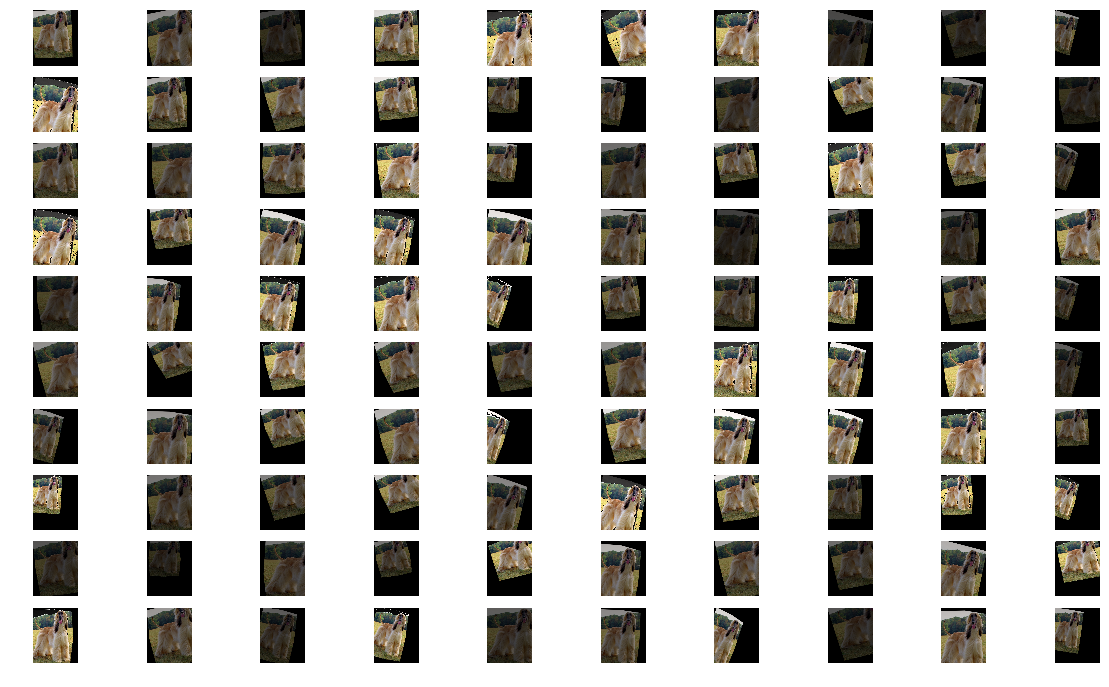

In [43]:
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(20,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    _img = transform_image(sample_image,20,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(_img)
    plt.axis('off')

plt.show()

The following code cell augments the data set to provide an even distribution across the classes

In [44]:
def augment_data(even_distribution=False, extra_samples_per_class=100):
    augmented_samples = []
    augmented_classes = []
    for sample_class in range(133):
        if even_distribution:
            samples_needed = class_count[max_class] - class_count[sample_class]
        else: 
            samples_needed = extra_samples_per_class
        for count in range(samples_needed):
            sample_image = cv2.imread(class_images[sample_index])
            sample_image =cv2.resize(sample_image,(224,224))
            sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
            sample_image_transformed = transform_image(sample_image,20,10,5)
            augmented_samples.append(sample_image_transformed)
            augmented_classes.append(feature_labels[sample_class])
    return  np.array(augmented_samples), np.array(augmented_classes)

In [45]:
augmented_samples, augmented_targets = augment_data(even_distribution=True)

In [46]:
print(len(augmented_targets))

3561


In [47]:
def img_to_tensor(img):
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [48]:
def imgs_to_tensor(images):
    list_of_tensors = [img_to_tensor(img) for img in tqdm(images)]
    return np.vstack(list_of_tensors)

In [49]:
%%time
augmented_image_tensors = imgs_to_tensor(augmented_samples)

100%|██████████| 3561/3561 [00:00<00:00, 4181.21it/s]


CPU times: user 588 ms, sys: 1.08 s, total: 1.67 s
Wall time: 1.65 s


In [50]:
%%time
all_tensors = np.concatenate((train_tensors, augmented_image_tensors))
all_targets = np.concatenate((train_targets, augmented_targets))

CPU times: user 1.07 s, sys: 1.26 s, total: 2.32 s
Wall time: 2.3 s


Training set count per class after augmentation..


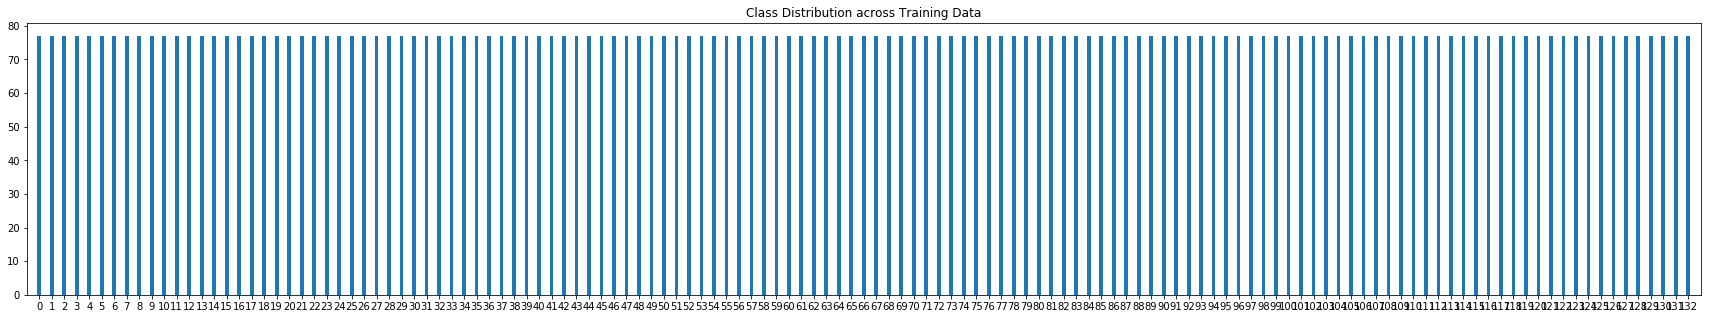

Minimum: Affenpinscher, 0 -> 77
Maximum: Affenpinscher, 0 -> 77


In [51]:
print("Training set count per class after augmentation..")
class_count = [0]*133
for index, label in enumerate(all_targets):
    label_class = np.argmax(label)
    class_count[label_class] += 1

min_class = 0
max_class = 0
for class_id, count in enumerate(class_count):
    if count < class_count[min_class]:
        min_class = class_id
    if count > class_count[max_class]:
        max_class = class_id
# Plot the histogram
plt.rcParams["figure.figsize"] = [30, 5]
axes = plt.gca()
axes.set_xlim([-1,133])

labels = range(133)
plt.bar(labels, class_count, tick_label=labels, width=0.3, align='center')
plt.title('Class Distribution across Training Data')
plt.show()
print("Minimum: {}, {} -> {}".format(dog_names[min_class], min_class, class_count[min_class]))
print("Maximum: {}, {} -> {}".format(dog_names[max_class], max_class, class_count[max_class]))

In [52]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(all_tensors, all_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 10241 samples, validate on 835 samples
Epoch 1/10
10241/10241 [==============================] - 34s - loss: 4.8933 - acc: 0.0055 - val_loss: 4.8901 - val_acc: 0.0072
Epoch 2/10
10241/10241 [==============================] - 33s - loss: 4.8933 - acc: 0.0048 - val_loss: 4.8903 - val_acc: 0.0096
Epoch 3/10
10241/10241 [==============================] - 33s - loss: 4.8933 - acc: 0.0061 - val_loss: 4.8906 - val_acc: 0.0048
Epoch 4/10
10241/10241 [==============================] - 33s - loss: 4.8933 - acc: 0.0047 - val_loss: 4.8908 - val_acc: 0.0048
Epoch 5/10
10241/10241 [==============================] - 33s - loss: 4.8932 - acc: 0.0056 - val_loss: 4.8908 - val_acc: 0.0072
Epoch 6/10
10241/10241 [==============================] - 33s - loss: 4.8933 - acc: 0.0045 - val_loss: 4.8909 - val_acc: 0.0096
Epoch 7/10
10241/10241 [==============================] - 33s - loss: 4.8933 - acc: 0.0048 - val_loss: 4.8910 - val_acc: 0.0060
Epoch 8/10
10241/10241 [==============================] 

### Load the Model with the Best Validation Loss

In [53]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [54]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 0.5981%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [55]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [56]:
train_VGG16.shape[1:]

(7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [57]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [58]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [59]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.1156 - acc: 0.1277 - val_loss: 10.8630 - val_acc: 0.1988
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 9.9572 - acc: 0.2943 - val_loss: 9.9694 - val_acc: 0.2707
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.3149 - acc: 0.3620 - val_loss: 9.6290 - val_acc: 0.3186
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.0506 - acc: 0.3933 - val_loss: 9.4083 - val_acc: 0.3198
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 8.8183 - acc: 0.4159 - val_loss: 9.4147 - val_acc: 0.3413
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 8.6994 - acc: 0.4322 - val_loss: 9.1168 - val_acc: 0.3581
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 8.6064 - acc: 0.4461 - val_loss: 9.1016 - val_acc: 0.3605
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.5774 - 

### Load the Model with the Best Validation Loss

In [60]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [61]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.1053%


### Predict Dog Breed with the Model

In [62]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [63]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I read an article about the Inception Archicture and how it rethought the conventional idea of "filters" in CNNs and increased its learning abilities by having more complex "filters" that can learn non-linear functions using multi-layer perceptions(which were basically 1 to 1 convolutions). I thought this was a good architecture to apply to the problem at hand since it could possibly learn more complex features, so I simply added a final layer to match the number of Dog breeds.



In [64]:
### TODO: Define your architecture.
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [65]:
### TODO: Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

As previously noted there was an uneven distribution across the class and the data was augmented in the code cells above to cause the distribution to shift from this

Training set count per class..


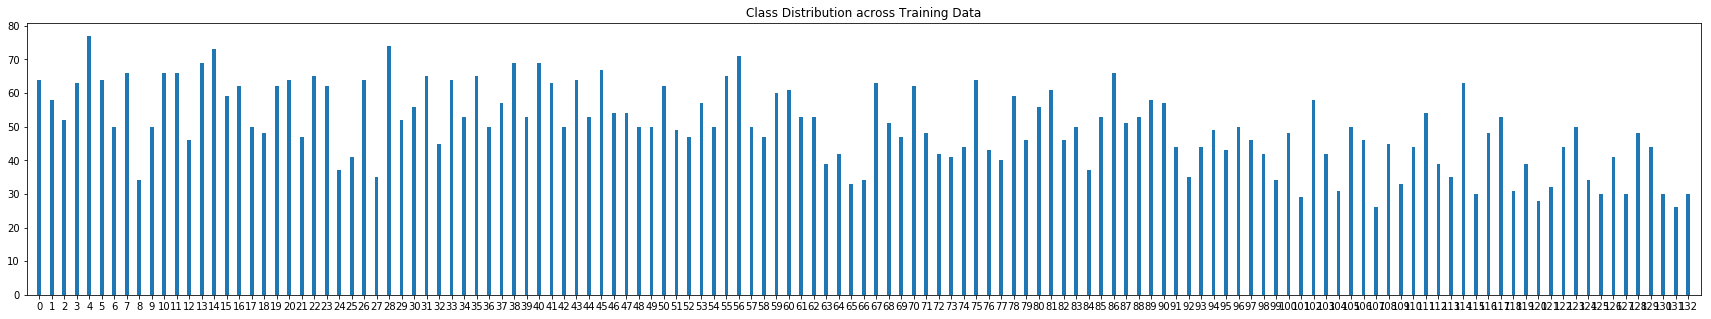

Minimum: Norwegian_buhund, 107 -> 26
Maximum: Alaskan_malamute, 4 -> 77


In [66]:
print("Training set count per class..")
class_count = [0]*133
class_images = [None]*133
feature_labels = [None]*133

for index, label in enumerate(train_targets):
    label_class = np.argmax(label)
    class_count[label_class] += 1
    class_images[label_class] = train_files[index]
    feature_labels[label_class] = label

min_class = 0
max_class = 0
for class_id, count in enumerate(class_count):
    if count < class_count[min_class]:
        min_class = class_id
    if count > class_count[max_class]:
        max_class = class_id
# Plot the histogram
plt.rcParams["figure.figsize"] = [30, 5]
axes = plt.gca()
axes.set_xlim([-1,133])

labels = range(133)
plt.bar(labels, class_count, tick_label=labels, width=0.3, align='center')
plt.title('Class Distribution across Training Data')
plt.show()
print("Minimum: {}, {} -> {}".format(dog_names[min_class], min_class, class_count[min_class]))
print("Maximum: {}, {} -> {}".format(dog_names[max_class], max_class, class_count[max_class]))

Training the model with this data achieved a 86% test accuracy after training over 20 epochs

To this..

Training set count per class after augmentation..


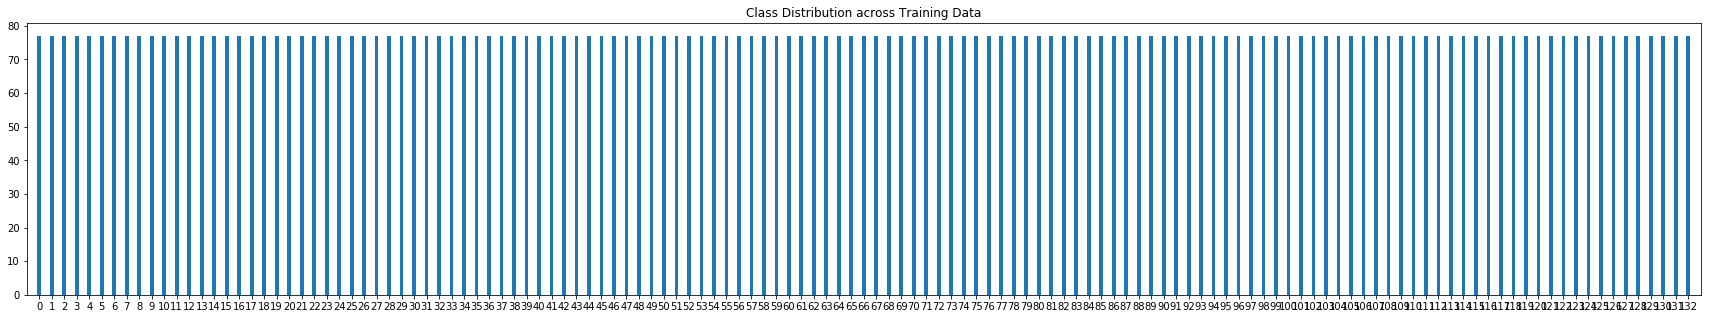

Minimum: Affenpinscher, 0 -> 77
Maximum: Affenpinscher, 0 -> 77


In [67]:
print("Training set count per class after augmentation..")
class_count = [0]*133
for index, label in enumerate(all_targets):
    label_class = np.argmax(label)
    class_count[label_class] += 1

min_class = 0
max_class = 0
for class_id, count in enumerate(class_count):
    if count < class_count[min_class]:
        min_class = class_id
    if count > class_count[max_class]:
        max_class = class_id
# Plot the histogram
plt.rcParams["figure.figsize"] = [30, 5]
axes = plt.gca()
axes.set_xlim([-1,133])

labels = range(133)
plt.bar(labels, class_count, tick_label=labels, width=0.3, align='center')
plt.title('Class Distribution across Training Data')
plt.show()
print("Minimum: {}, {} -> {}".format(dog_names[min_class], min_class, class_count[min_class]))
print("Maximum: {}, {} -> {}".format(dog_names[max_class], max_class, class_count[max_class]))

The features from the augmented data samples were then combined with the current dataset and then used to train the model. It surprisingly achieved a test accuracy of 77% after training over 20 epochs. 

### Extract the features

In [68]:
%%time
augmented_bottleneck_features = extract_InceptionV3(augmented_image_tensors)

CPU times: user 47.1 s, sys: 2.88 s, total: 50 s
Wall time: 43.4 s


In [69]:
all_InceptionV3_features = np.concatenate((train_InceptionV3, augmented_bottleneck_features))

Thinking about it some more, if the test data was as skewed as the training data it would've been expected for this model to not do as well. 

I think to combat this I have a few options to help the model generalize better,

* Increase the number of epochs
* Increase the number of samples in the training set 

Results, 

**Increase the number of epochs** - 78% test accuracy over 100 epochs


In [70]:
augmented_samples_500, augmented_targets_500 = augment_data(extra_samples_per_class=500)

In [ ]:
%%time
augmented_imgs_tensor_500 = imgs_to_tensor(augmented_samples_500)

In [ ]:
%%time
augmented_bottleneck_features_500 = extract_InceptionV3(augmented_imgs_tensor_500)

In [71]:
all_InceptionV3_features_500 = np.concatenate((all_InceptionV3_features, augmented_bottleneck_features_500))
all_InceptionV3_targets_500 = np.concatenate((all_targets, augmented_targets_500))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(all_InceptionV3_features_500, all_InceptionV3_targets_500, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=100, batch_size=20, callbacks=[checkpointer], verbose=1)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def InceptionV3_predict_breed(img_path):
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def face_or_dog_detected(img_path):
    return InceptionV3_predict_breed(img_path)

def show_output(img_path, text=''):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    print(text)
    
def detector(img_path):
    breed = InceptionV3_predict_breed(img_path)
    if improved_face_detector(img_path):
        message = 'This face looks like a.... {}'.format(breed)
    elif dog_detector(img_path):
        message = 'The dog breed is a.... {}'.format(breed)
    else:
        message = 'I don\'t know what this is :/'
    return message

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ It's as expected... Bad! :( The reasons I expected this is 
1. I didn't augment the data which means the model will have a tough time recognizing breeds when the face might not be at full focus
2. I don't think color is as important to detecting dog breeds as other features but this approach doesn't convert to grayscale so the model has 3 color channels to deal with which I think makes it harder
3. There might not have been enough samples in the dataset of one or more specific breeds, making it difficult for the model to properly predict some breeds.

In [ ]:
import glob # Python library to read files easier
test_images = glob.glob('test_images/*.jpg')
print(test_images)

In [ ]:
fig, ax = plt.subplots(nrows=len(test_images), ncols=1, figsize=(24, 20))
for i, test_image in enumerate(test_images):
    img = cv2.imread(test_image)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = detector(test_image)
    ax[i].set_title(result, fontsize=20)
    ax[i].imshow(cv_rgb)